In [1]:
import pandas as pd
import numpy as np
path = "ECAI"

def get_intersection(v01, ve1, v02, ve2, max_weight=10):
    # handle division by zero masking out the positions where the denominator is zero
    denominator = ve2 - ve1
    if isinstance(denominator, np.ndarray):
        denominator[denominator == 0] = np.nan
    else:
        if denominator == 0:
            return np.nan
    wes = (v01 - v02) / denominator
    return np.round(wes[(wes >= 0) & (wes <= max_weight)], 2)


In [2]:
# New method
folder = lambda db, eff, we : f"/db{db}_effrate{eff}_we{we}_ECAI"
unethical = pd.read_csv(path + folder(0, 0.2, 0)*2  + "/mo_rewards.csv")
unethical_np = unethical.to_numpy().reshape(-1, 5, 2)
ethical = pd.read_csv(path + folder(1, 0.2, 10)*2  + "/mo_rewards.csv")
ethical_np = ethical.to_numpy().reshape(-1, 5, 2)

# wes  = get_intersection(ethical_np[:, 0, 0], ethical_np[:, 0, 1], unethical_np[:, 0, 1], unethical_np[:, 0, 1])
wes = get_intersection(unethical_np[:, 0, 0], unethical_np[:, 0, 1], ethical_np[:, 0, 0], ethical_np[:, 0, 1])
wes.mean(), wes.std(), np.median(wes)

(2.4719976019184653, 1.6991766139698001, 2.18)

In [3]:
# Old method
folder = lambda db, eff, we : f"/db{db}_effrate{eff}_we{we}_ECAI"
unethical = pd.read_csv(path + folder(0, 0.2, 0)*2  + "/mo_rewards.csv")
unethical_np = unethical.to_numpy().reshape(-1, 5, 2).mean(axis=0)
ethical = pd.read_csv(path + folder(1, 0.2, 10)*2  + "/mo_rewards.csv")
ethical_np = ethical.to_numpy().reshape(-1, 5, 2).mean(axis=0)

wes  = get_intersection(unethical_np[0, 0], unethical_np[0, 1], ethical_np[0, 0], ethical_np[0, 1])
wes.mean(), wes.std()

(1.75, 0.0)

In [4]:
# New By groups of 500

unethical = pd.read_csv(path + folder(0, 0.2, 0)*2  + "/mo_rewards.csv")
unethical_np = unethical.to_numpy().reshape(-1, 5, 2)
ethical = pd.read_csv(path + folder(1, 0.2, 10)*2  + "/mo_rewards.csv")
ethical_np = ethical.to_numpy().reshape(-1, 5, 2)
unethical_np = unethical_np.reshape(-1, 500, 5, 2)
ethical_np = ethical_np.reshape(-1, 500, 5, 2)

wes = []
for i in range(unethical_np.shape[0]):
    wes.append(get_intersection(unethical_np[i, :, 0, 0], unethical_np[i, :, 0, 1], ethical_np[i, :, 0, 0], ethical_np[i, :, 0, 1]))
    
for we in wes:
    print(we.mean().round(2), "+-", we.std().round(2), "Median" ,np.median(we))

2.37 +- 1.73 Median 2.08
2.53 +- 1.73 Median 2.23
2.48 +- 1.65 Median 2.2
2.49 +- 1.74 Median 2.09
2.42 +- 1.72 Median 2.09
2.34 +- 1.57 Median 2.12
2.52 +- 1.74 Median 2.15
2.59 +- 1.81 Median 2.34
2.47 +- 1.66 Median 2.2
2.5 +- 1.6 Median 2.31


In [5]:
# Old By groups of 500

unethical = pd.read_csv(path + folder(0, 0.2, 0)*2  + "/mo_rewards.csv")
unethical_np = unethical.to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)
ethical = pd.read_csv(path + folder(1, 0.2, 10)*2  + "/mo_rewards.csv")
ethical_np = ethical.to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)

wes = []
for i in range(unethical_np.shape[0]):
    wes.append(get_intersection(unethical_np[i, 0, 0], unethical_np[i, 0, 1], ethical_np[i,0, 0], ethical_np[i, 0, 1]))
    
we = np.array(wes)
we.mean(axis=0), we.std(axis=0), np.median(we, axis=0)

(array([1.756]), array([0.13821722]), array([1.74]))

In [12]:
eff_rates = [0, 0.2, 0.6, 1]
dbs = [0, 1, 10, 100]

we = np.zeros((len(eff_rates), len(dbs), 10))
we_std = np.zeros((len(eff_rates), len(dbs)))
we_median = np.zeros((len(eff_rates), len(dbs)))

for eff_rate in eff_rates:
    for db in dbs:
        if eff_rate == 0:
            continue
        
        unethical = pd.read_csv(path + folder(0, eff_rate, 0)*2  + "/mo_rewards.csv")
        unethical_np = unethical.to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)
        
        if eff_rate == 1 and db == 1:   
            ethical = pd.read_csv(path + folder(db, eff_rate, 20)*2  + "/mo_rewards.csv")
        else:
            ethical = pd.read_csv(path + folder(db, eff_rate, 10)*2  + "/mo_rewards.csv")
        ethical_np = ethical.to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)

        wes = []
        for i in range(unethical_np.shape[0]):
            wag = []
            for ag in range(5):
                max_weight = 20 if db == 1 and eff_rate == 1 else 10
                w = get_intersection(unethical_np[i, ag, 0], unethical_np[i, ag, 1], ethical_np[i, ag, 0], ethical_np[i, ag, 1], max_weight=max_weight)
                if not np.isnan(w).all():
                    wag.append(w)
            if np.isnan(wag).all():
                continue
            wes.append(np.mean(wag))
        if len(wes) == 0:
            continue
        we[eff_rates.index(eff_rate), dbs.index(db)] = np.array(wes)
        """we[eff_rates.index(eff_rate), dbs.index(db)] = np.array(wes).mean(axis=0).squeeze()
        we_std[eff_rates.index(eff_rate), dbs.index(db)] = np.array(wes).std(axis=0).squeeze()
        we_median[eff_rates.index(eff_rate), dbs.index(db)] = np.median(np.array(wes), axis=0).squeeze()"""
we[eff_rates.index(1), 1:].mean(axis=1)

array([7.262, 5.841, 1.989])

In [13]:
we[eff_rates.index(1), 1:].std(axis=1)

array([1.19477446, 0.32344689, 0.14346358])

In [15]:
np.median(we[eff_rates.index(1), 1:], axis=1)

array([7.3975    , 5.85666667, 2.03      ])

In [9]:
# Print as latex row for table with standard deviation
for eff_rate in [0.2, 0.6, 1]:
    print(f"{int(eff_rate*100)}\% & ", end="")
    for db in [0, 1, 10, 100]:
        mean = we[eff_rates.index(eff_rate), dbs.index(db)].mean().round(2)
        std = we[eff_rates.index(eff_rate), dbs.index(db)].std().round(2)
        if db == 100:
            print(f"{mean} \\pm {std} ", end="")
        else:
            print(f"{mean} \\pm {std} & ", end="")
    print("\\\\")

20\% & 0.0 \pm 0.0 & 1.76 \pm 0.14 & 1.58 \pm 0.12 & 1.32 \pm 0.08 \\
60\% & 0.0 \pm 0.0 & 4.4 \pm 1.78 & 2.21 \pm 0.24 & 1.82 \pm 0.09 \\
100\% & 0.0 \pm 0.0 & 7.26 \pm 1.19 & 5.84 \pm 0.32 & 1.99 \pm 0.14 \\


In [10]:
for db in dbs:
    print(we[eff_rates.index(0.2), dbs.index(db)].mean())

0.0
1.7559999999999998
1.585
1.319


[-183.2   -0.2]
[-102.7   -0.2]
[-1.806e+02 -1.000e-01]
[-1.648e+02 -1.000e-01]
[-154.5   -0. ]
[4.97]
[]
[]
[]
[4.83]


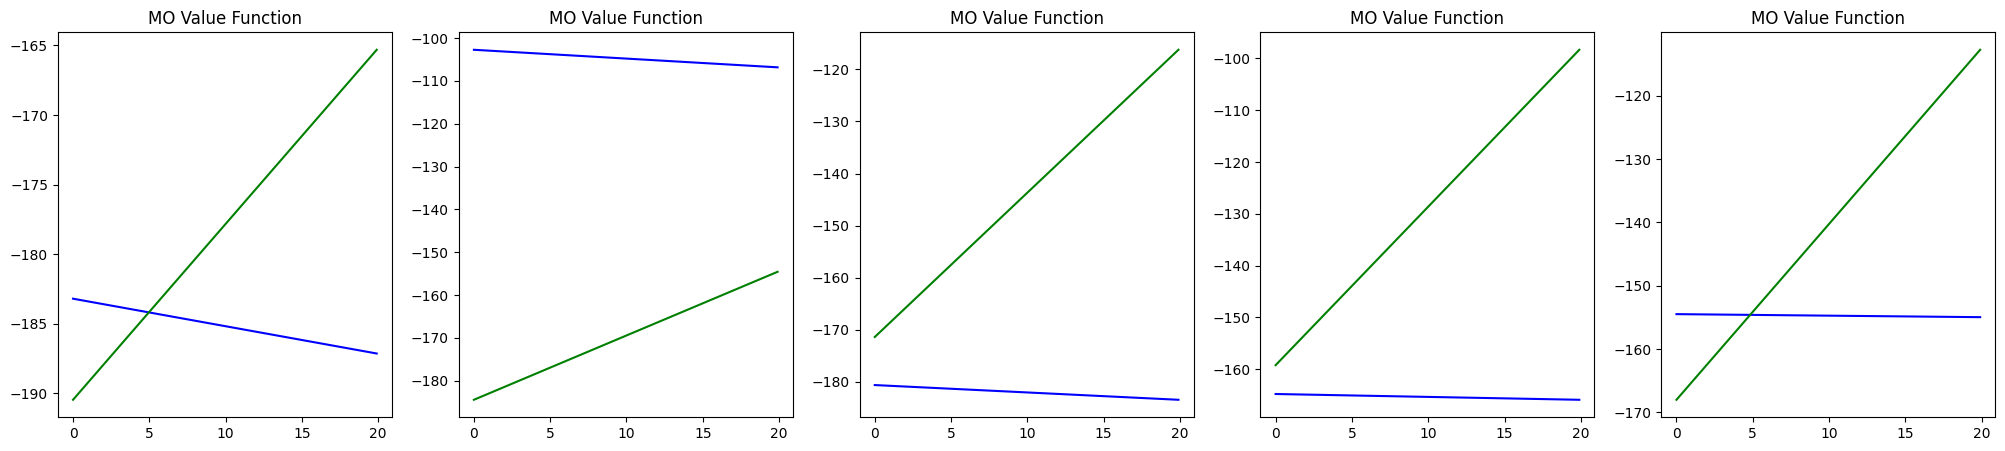

In [11]:
# Plot values as function of weight w that scales the reward
import matplotlib.pyplot as plt
import  matplotlib
# matplotlib.use("Qt5Agg")
ref = pd.read_csv(path + folder(1, 1, 20)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0]

unet = pd.read_csv(path + folder(0, 1, 0)*2  + "/mo_rewards.csv").to_numpy().reshape(-1, 500, 5, 2).mean(axis=1)[0]

#ref = np.array([[-2.91336e+02, -5.10000e-02], [-254.629, 0.447], [-100.569, 19.0925], [-217.956, 0.], [-110.72, 17.7443]])
#unet = np.array([[-498.81, 0. ], [-499.496, 0. ], [-50.38, -0.594], [-498.619, 0. ], [-84.982, -0.364]])
fig, axs = plt.subplots(1, 5, figsize=(25, 5)) 
step = 0.1
# for ag in mo_value_w10:
max_weight = 20
# Subplot for each agent
x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])
for i, ag in enumerate(range(5)):
    axs[i].set_title("MO Value Function")
    print(np.round(unet[ag], 1))
    axs[i].plot(x, np.dot(unet[ag], w), c="blue")
    axs[i].plot(x, np.dot(ref[ag], w), c="green")
    
wes = []
for ag in range(5):
    # Print intersecctions
    inter = get_intersection(unet[ag, 0], unet[ag, 1], ref[ag, 0], ref[ag, 1], max_weight=max_weight)
    print(inter)
    wes.append(inter)
plt.show()